## This notebook explores the adiabatic method

In [35]:
using Bloqade
using Random
using Optim
Random.seed!(42)
using PythonCall
plt = pyimport("matplotlib.pyplot");
using GenericTensorNetworks

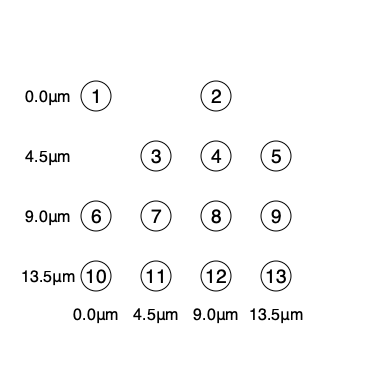

In [17]:
Random.seed!(2)
a=4.5
atoms = generate_sites(SquareLattice(), 4,4; scale = a) |> random_dropout(0.2)

In [18]:
Rb=sqrt(3*sqrt(5))*a
blockade_radius = Rb

11.65509028850108

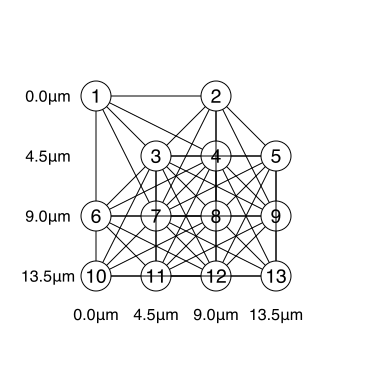

In [19]:
Bloqade.plot(atoms, blockade_radius = Rb)

But first, Classically

In [26]:
unit_graph = unit_disk_graph(atoms, Rb)
configs = GenericTensorNetworks.solve(IndependentSet(unit_graph), ConfigsMax())[]
MIS_config = configs.c[1]

1000100001000

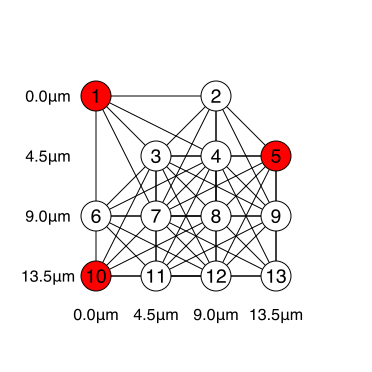

In [27]:
Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in MIS_config])

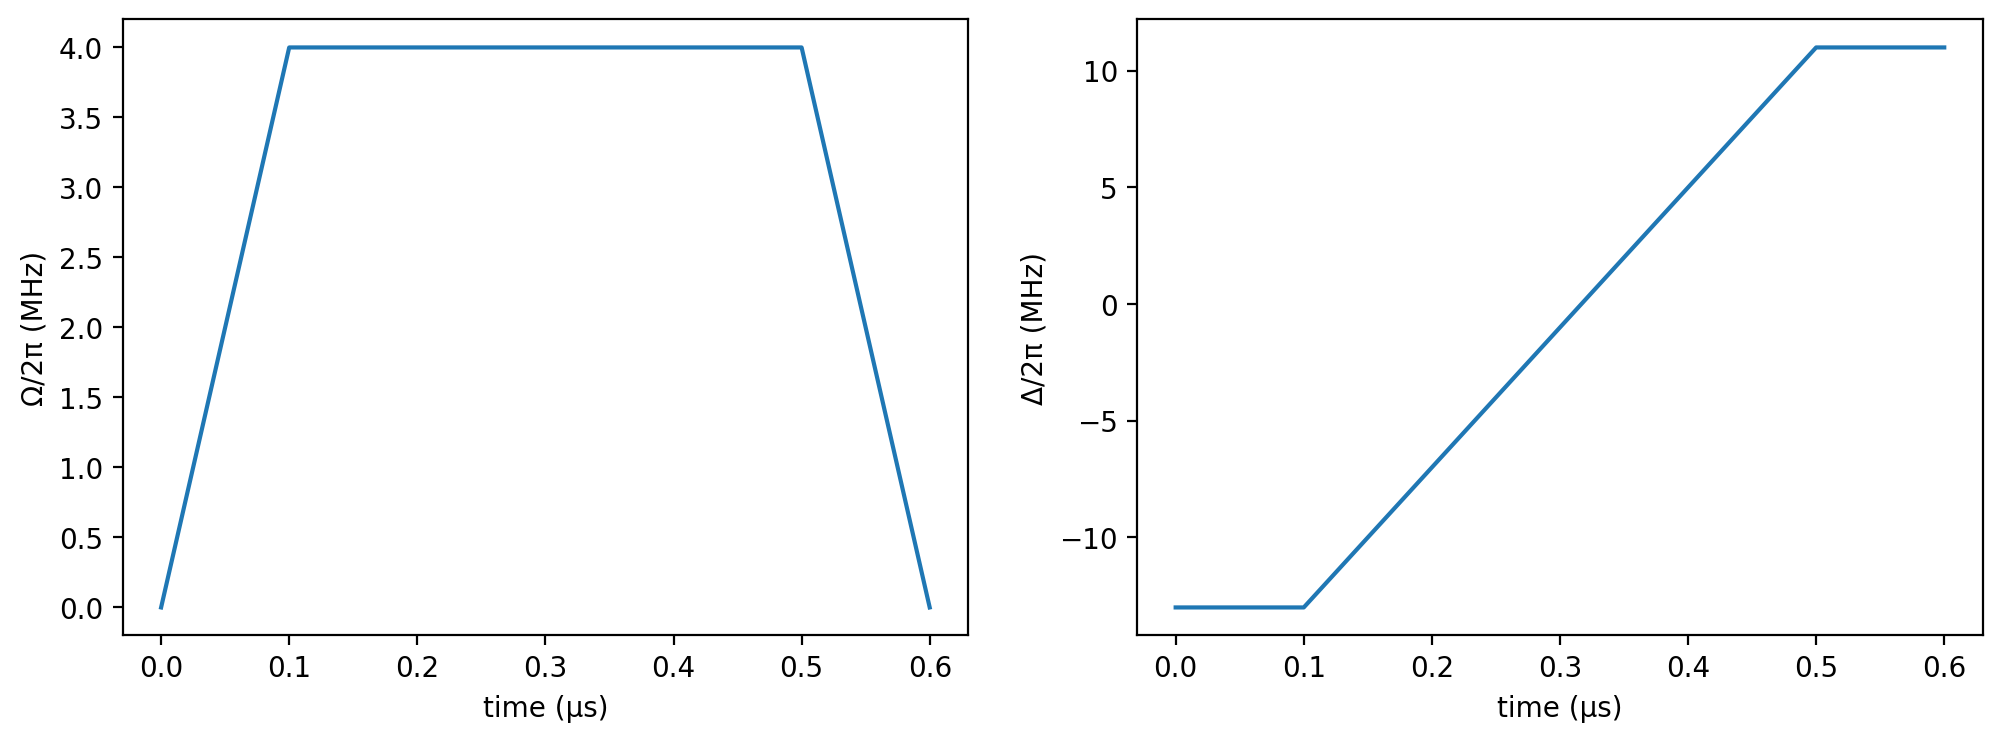

In [28]:
T_max = 0.6
Ω_max = 2π * 4
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -2π * 13
Δ_end = 2π * 11
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])

plot, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
plot

In [29]:
hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ, ϕ=Waveform(t->0.0, T_max))
prob = SchrodingerProblem(zero_state(nqubits(hamiltonian)), T_max, hamiltonian)
emulate!(prob)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.6)

  equation: 
    storage size: 2.563 MiB
    expression:
nqubits: 13
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] Ω(t) ⋅∑ e^{ϕ(t) ⋅ im} |0⟩⟨1| + e^{-ϕ(t) ⋅ im} |1⟩⟨0|
└─ [-] Δ(t) ⋅ ∑ n_i


    algorithm: DP8(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false),)
  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false
    reltol: 1.0e-10
    abstol: 1.0e-10
    alias_u0: true


In [31]:
function get_MIS_prob(reg::Union{ArrayReg, SubspaceArrayReg}, configs) # want to maxmimize this
    prob = 0
    x = [parse(Int, reverse(string(x)); base=2) for x in configs.c]
    for (c, amp) in BloqadeMIS.ConfigAmplitude(reg)
        if c in x
            prob+=abs2(amp)
        end
    end
    return prob
end

get_MIS_prob(prob.reg, configs)

0.00999609171138984

In [32]:
function get_waves(params::Vector{Float64}) # returns the pulses as a function of certain parameters
    t_start, t_end, scale... = params
    t_start+=0.03
    T_max = 0.6
    t_end = T_max - t_end - 0.03
    t_interval = (t_end - t_start) / (length(scale) + 1)
    Ω_max = 4 * 2π
    Δ_start = -13 * 2π
    Δ_end = Δ0 = 11 * 2π

    Δ_clock = [0.0, t_start]
    Δ_val = [Δ_start, Δ_start]
    for i in 1:length(scale)
        push!(Δ_val, Δ0*scale[i])
        push!(Δ_clock, t_start + i*t_interval)
    end
    push!(Δ_val, Δ_end); push!(Δ_val, Δ_end)
    push!(Δ_clock, t_end); push!(Δ_clock, T_max)
    Δ = piecewise_linear(clocks = Δ_clock, values = Δ_val);
    Ω = piecewise_linear(clocks = [0.0, t_start, t_end, T_max], values = [0, Ω_max, Ω_max, 0]);
    return Ω, Δ
end

get_waves (generic function with 1 method)

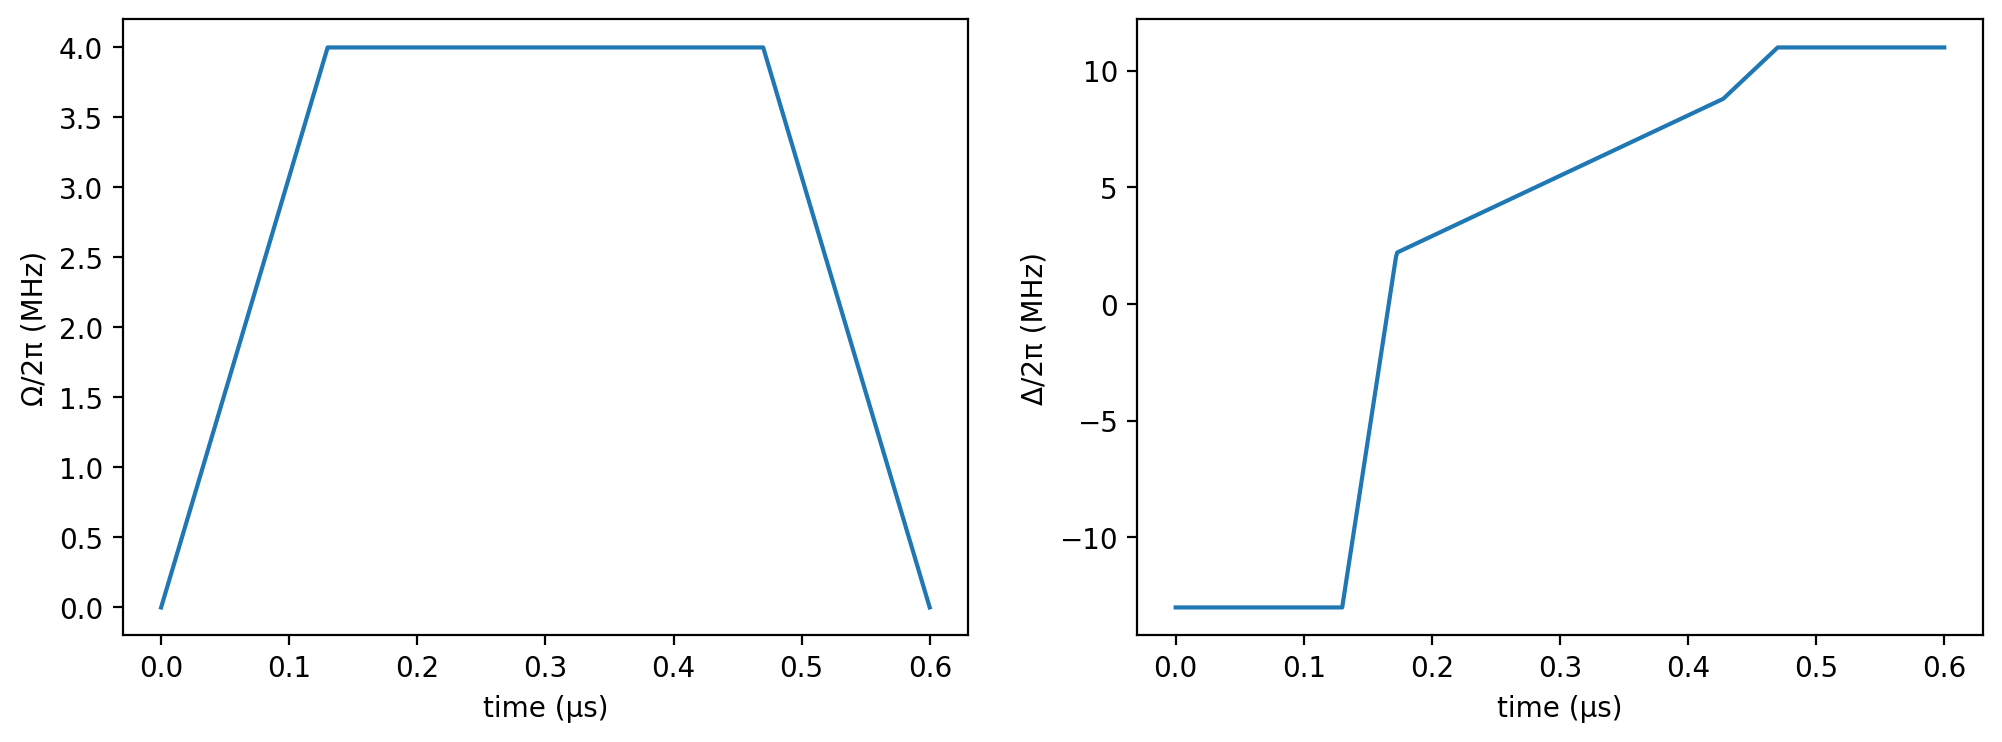

In [33]:
function plot_waves(params::Vector{Float64})
    Ω, Δ = get_waves(params)

    graph, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
    Bloqade.plot!(ax1, Ω)
    ax1.set_ylabel("Ω/2π (MHz)")
    Bloqade.plot!(ax2, Δ)
    ax2.set_ylabel("Δ/2π (MHz)")
    return graph
end

x0 = [0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

plot_waves(x0)

In [36]:
function loss(atoms::AtomList, x::Vector{Float64}, configs)
    Ω, Δ = get_waves(x)
    hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)
    subspace = blockade_subspace(atoms, 4.5)
    prob = SchrodingerProblem(zero_state(subspace), T_max, hamiltonian)
    emulate!(prob)
    return -get_MIS_prob(prob.reg, configs), prob.reg, Δ
end

optresult = Optim.optimize(x -> loss(atoms, x, configs)[1], x0)

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     -2.920182e-01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   149  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    1471


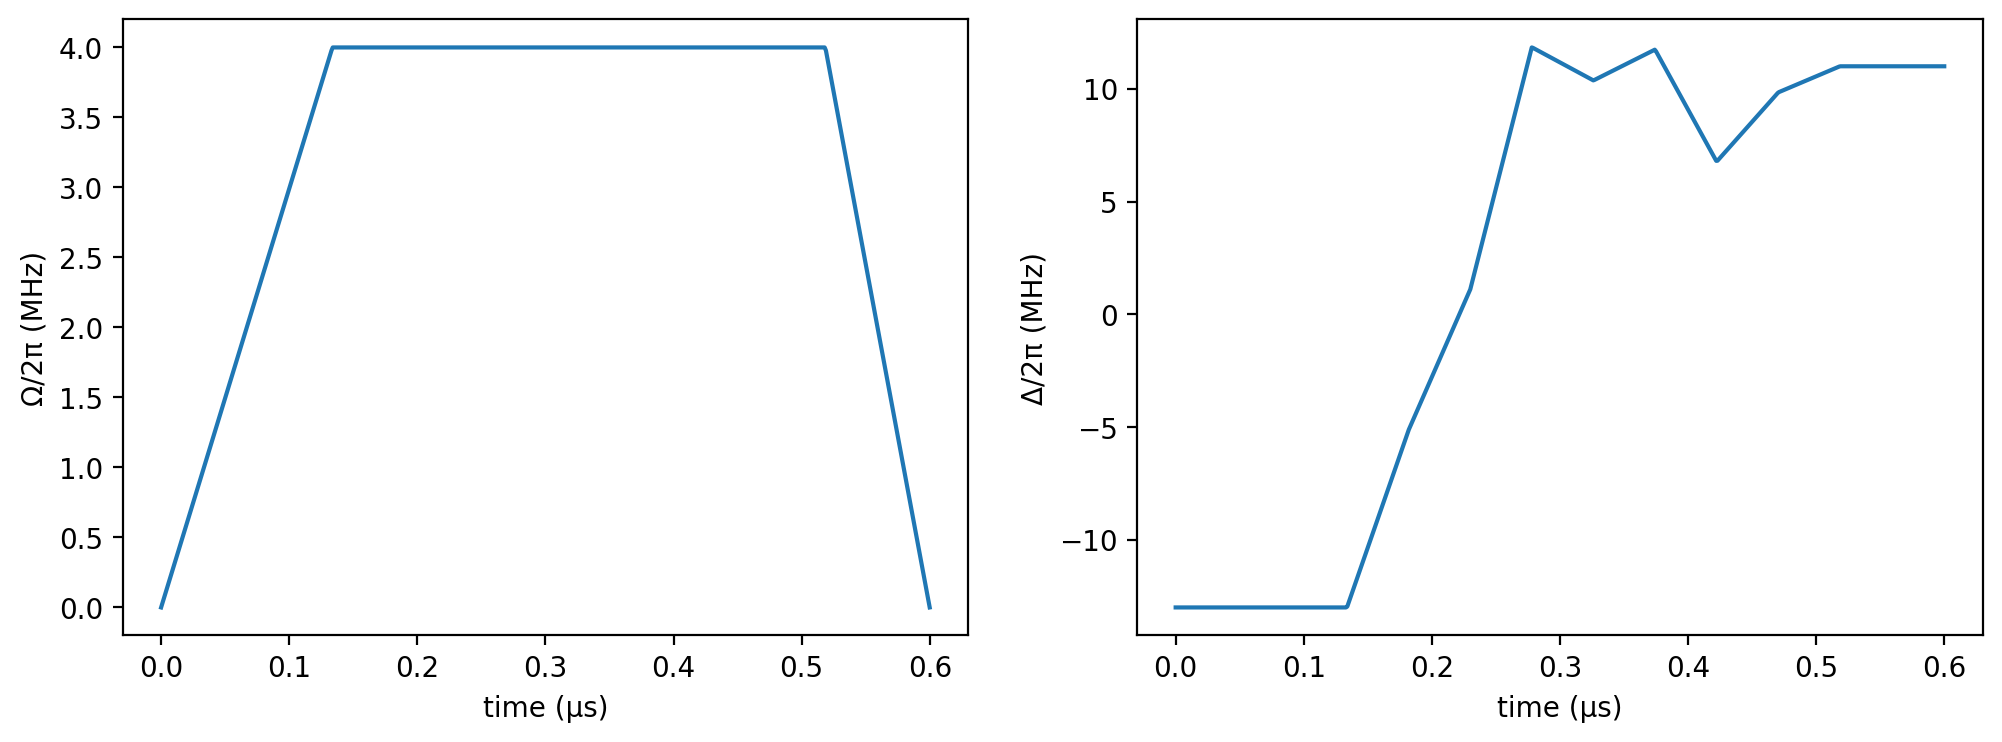

In [37]:
plot_waves(optresult.minimizer)

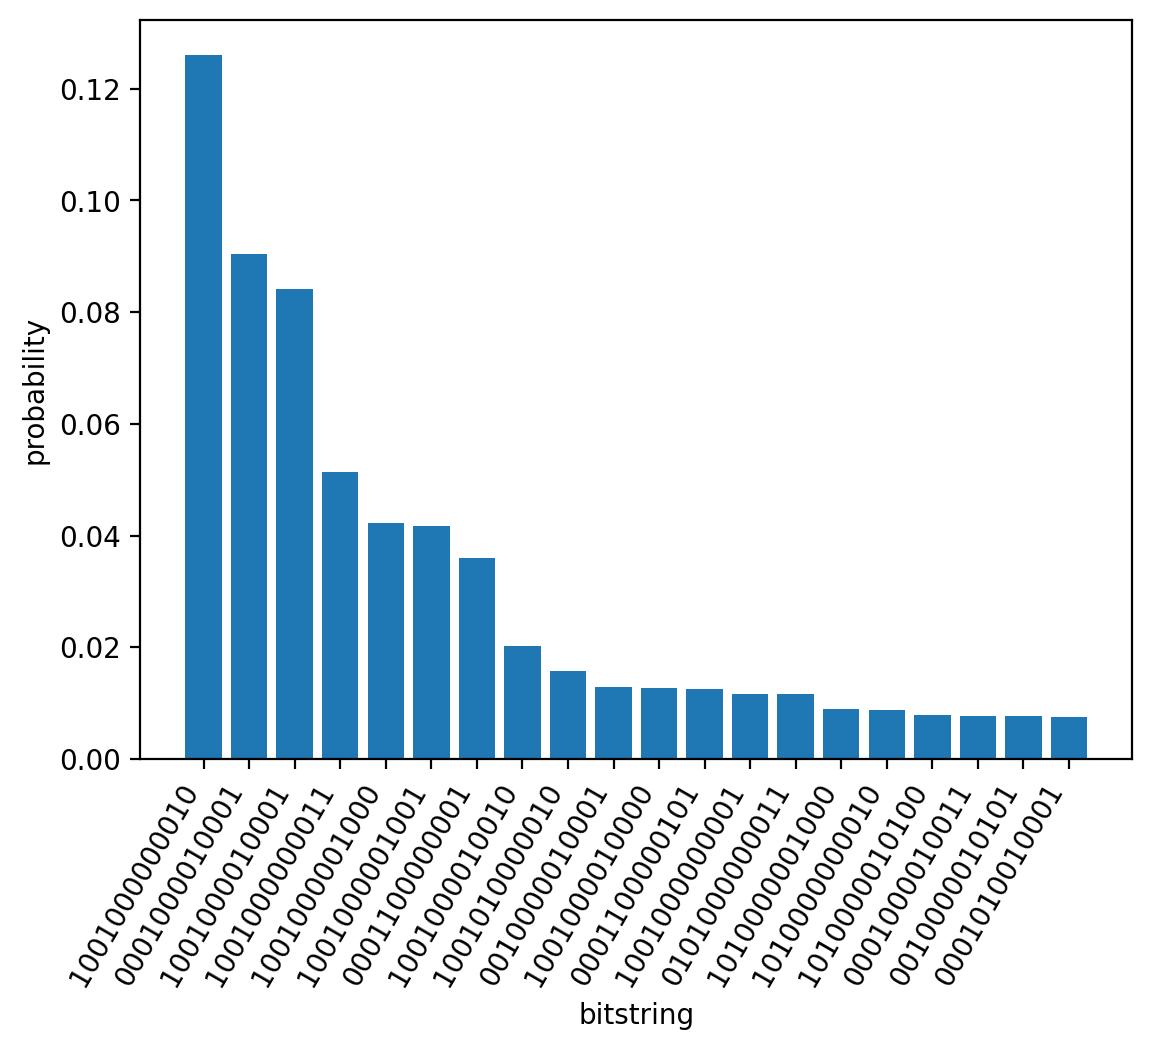

In [38]:
Ω, Δ = get_waves(optresult.minimizer)
hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ, ϕ=Waveform(t->0.0, T_max))
prob = SchrodingerProblem(zero_state(nqubits(hamiltonian)), T_max, hamiltonian)
emulate!(prob)

bitstring_hist(prob.reg; nlargest = 20)

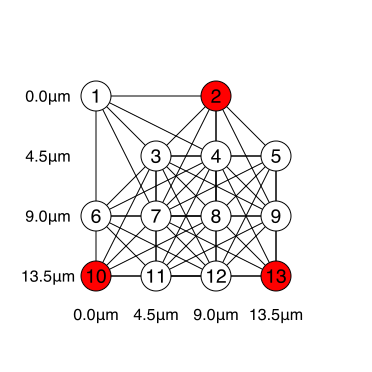

In [39]:
best_bit_strings = most_probable(prob.reg, 3)

Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])

# First Attempt

In [ ]:
#Total evolution time
T_max = 3

#Fix Δ according to the desired Rydberg radius
C6 = 2π * 862690;
Ω_max = 2π*2.5
Δ_max = C6 / Rb^6
a=.8
#Build time traces for adiabatic algorithm
Ω = piecewise_linear(clocks = [0.0, 0.25, 2.75, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -Δ_max
Δ_end = Δ_max
# Δ = piecewise_linear(clocks = [0.0, 0.75, 2.25, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])
w1 = constant(duration=0.25, value=Δ_start)
# w2 = Waveform( t ->  (a * (t)^3) - (4.5*a*(t)^2) + (6.75 * a * (t)) + Δ_max - (5.327*a), duration = 2.5)
w2 = Waveform(t->(((1.36*sin((1.05*t)-(3.14/2)))^3) + (2.162/3.14*(0.4))), duration = 2.5)
w3 = constant(duration=0.25, value=Δ_end)
Δ = append(append(w1, w2), w3)
#Quick plot to check
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [ ]:
h_kings = rydberg_h(atoms; Ω = Ω, Δ = Δ)
prob = SchrodingerProblem(zero_state(nqubits(h_kings)), T_max, h_kings);

In [ ]:
emulate!(prob)

In [ ]:
bitstring_hist(prob.reg; nlargest = 10)

In [ ]:
best_bit_strings = most_probable(prob.reg, 3)

Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])